# Using GridSearchCv for finding best results

## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import tensorflow as tf
import itertools
import time
import os
from datetime import datetime

np.random.seed(42)
tf.random.set_seed(42)

## Load And Preprocess

In [ ]:
def load_and_preprocess_data(train_file, test_file):

    dataset_train = pd.read_csv(train_file)
    dataset_train['date'] = pd.to_datetime(dataset_train['date'], format='%d-%m-%Y %H:%M')
    dataset_train['hour'] = dataset_train['date'].dt.hour
    dataset_train['minute'] = dataset_train['date'].dt.minute
    dataset_train.drop(columns=['date'], inplace=True)
  
    features = ['Soil Moisture Resistance (Ohm)', 'Ambient Temperature (deg. C)', 
                'Atmospheric Humidity (%)', 'hour', 'minute']
    target = 'DC Water pump Status'
    
 
    scaler = MinMaxScaler()
    dataset_train[features] = scaler.fit_transform(dataset_train[features])
    
    test_df = pd.read_csv(test_file)
    test_df['date'] = pd.to_datetime(test_df['date'], format='%d-%m-%Y %H:%M')
    test_df['hour'] = test_df['date'].dt.hour
    test_df['minute'] = test_df['date'].dt.minute
    test_df.drop(columns=['date'], inplace=True)
    test_df[features] = scaler.transform(test_df[features])
    
    return dataset_train, test_df, features, target, scaler

## Create Model

In [4]:
def create_sequences(data, target_col, time_steps=3):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(target_col[i + time_steps])
    return np.array(X), np.array(y).reshape(-1, 1)

In [ ]:
def create_model(conv_filters1=64, conv_filters2=128, 
                 lstm_units1=50, lstm_units2=100, lstm_units3=100, lstm_units4=100,
                 dropout_rate=0.2, learning_rate=0.001, input_shape=(3, 5)):
    
    model = Sequential()
    
    # First Conv1D layer
    model.add(Conv1D(filters=conv_filters1, kernel_size=3, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    # Second Conv1D layer
    model.add(Conv1D(filters=conv_filters2, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dropout_rate))
    
    # LSTM layers
    model.add(LSTM(units=lstm_units1, return_sequences=True))
    model.add(Dropout(dropout_rate))
    
    model.add(LSTM(units=lstm_units2, return_sequences=True))
    model.add(Dropout(dropout_rate))
    
    model.add(LSTM(units=lstm_units3, return_sequences=True))
    model.add(Dropout(dropout_rate))
    
    model.add(LSTM(units=lstm_units4, return_sequences=False))
    model.add(Dropout(dropout_rate))
    

    model.add(Dense(units=1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


## Custom Grid Search

In [ ]:
def custom_grid_search(X_train, y_train, X_val, y_val, param_grid, epochs=20, batch_size=32):
    results = []
    best_val_accuracy = 0
    best_model = None
    best_params = None
    

    param_combinations = list(itertools.product(*param_grid.values()))
    param_names = list(param_grid.keys())
    
    print(f"Total combinations to try: {len(param_combinations)}")
    
    for i, param_values in enumerate(param_combinations):
        # Create parameter dictionary
        params = dict(zip(param_names, param_values))
        print(f"\nCombination {i+1}/{len(param_combinations)}")
        print(f"Parameters: {params}")
        
        model = create_model(
            conv_filters1=params.get('conv_filters1', 64),
            conv_filters2=params.get('conv_filters2', 128),
            lstm_units1=params.get('lstm_units1', 50),
            lstm_units2=params.get('lstm_units2', 100),
            lstm_units3=params.get('lstm_units3', 100),
            lstm_units4=params.get('lstm_units4', 100),
            dropout_rate=params.get('dropout_rate', 0.2),
            learning_rate=params.get('learning_rate', 0.001),
            input_shape=(X_train.shape[1], X_train.shape[2])
        )
        
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
        
        start_time = time.time()
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping],
            verbose=1
        )
        training_time = time.time() - start_time
        
        val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
        
        result = {
            'params': params,
            'val_accuracy': val_accuracy,
            'val_loss': val_loss,
            'training_time': training_time,
            'epochs_completed': len(history.history['accuracy']),
            'history': history.history
        }
        
        results.append(result)
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model
            best_params = params
        
        print(f"Validation accuracy: {val_accuracy:.4f}, Validation loss: {val_loss:.4f}")
        print(f"Training time: {training_time:.2f} seconds")
    
    
    results.sort(key=lambda x: x['val_accuracy'], reverse=True)
    
    return results, best_model, best_params

## Main Code

Training set size: 3456
Validation set size: 864
X_train shape: (3453, 3, 5)
y_train shape: (3453, 1)
X_val shape: (861, 3, 5)
y_val shape: (861, 1)
Starting hyperparameter search...
Total combinations to try: 128

Combination 1/128
Parameters: {'conv_filters1': 32, 'lstm_units1': 50, 'dropout_rate': 0.2, 'learning_rate': 0.001}
Epoch 1/20


c:\Users\khach\.conda\envs\ml-project-tf-gpu\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5100 - loss: 0.6893 - val_accuracy: 0.2776 - val_loss: 0.7096
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6324 - loss: 0.6190 - val_accuracy: 0.3333 - val_loss: 0.7237
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6606 - loss: 0.5921 - val_accuracy: 0.6934 - val_loss: 0.6470
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6690 - loss: 0.5903 - val_accuracy: 0.7143 - val_loss: 0.5942
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6880 - loss: 0.5813 - val_accuracy: 0.7166 - val_loss: 0.5870
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6823 - loss: 0.5750 - val_accuracy: 0.6969 - val_loss: 0.6061
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6971 - loss: 0.5666 - val_accuracy: 0.7166 - val_loss: 0.5726
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6996 - loss: 0.5602 - val_accuracy: 0.6864 - val

Test Accuracy: 0.6701, Test Loss: 0.6358

Saving best model...


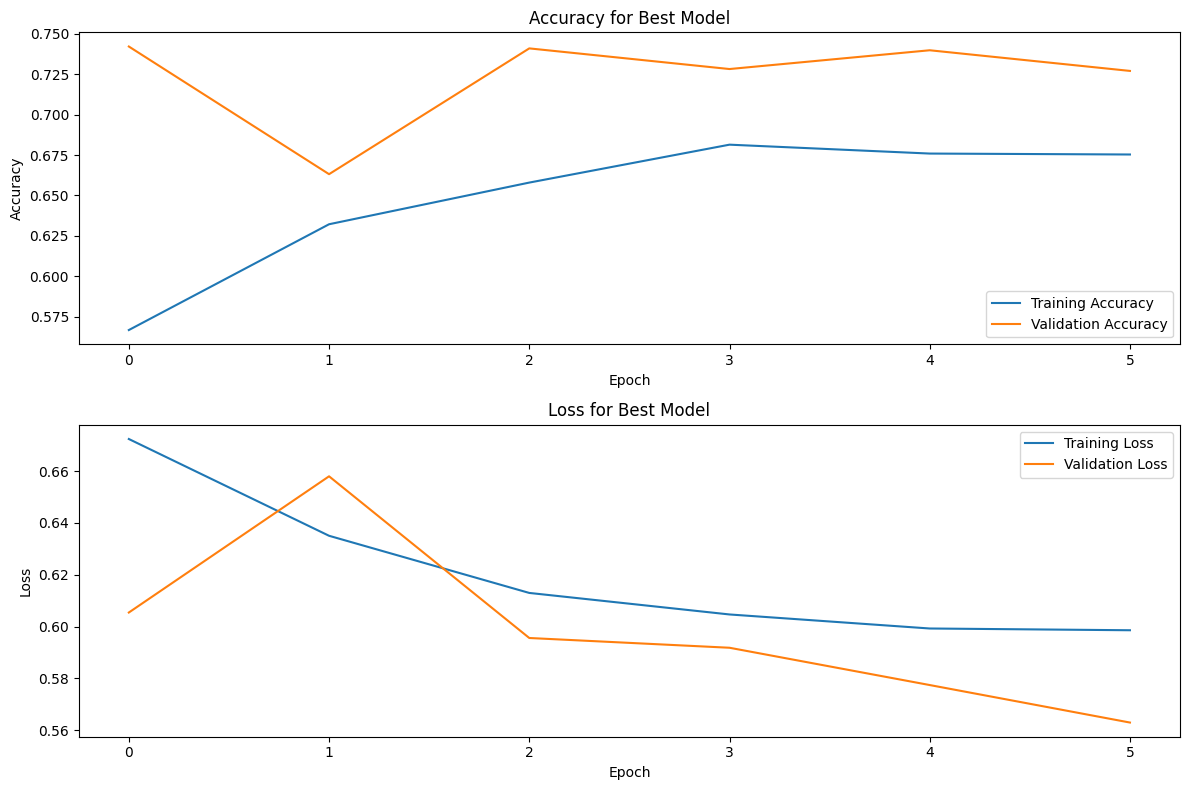


Best hyperparameters: {'conv_filters1': 32, 'lstm_units1': 100, 'dropout_rate': 0.5, 'learning_rate': 0.004}


'\nimport keras_tuner as kt\n\ndef model_builder(hp):\n    # Define hyperparameter search space\n    conv_filters1 = hp.Int(\'conv_filters1\', min_value=32, max_value=128, step=32)\n    conv_filters2 = hp.Int(\'conv_filters2\', min_value=64, max_value=256, step=64)\n    \n    lstm_units1 = hp.Int(\'lstm_units1\', min_value=50, max_value=150, step=50)\n    lstm_units2 = hp.Int(\'lstm_units2\', min_value=50, max_value=150, step=50)\n    lstm_units3 = hp.Int(\'lstm_units3\', min_value=50, max_value=150, step=50)\n    lstm_units4 = hp.Int(\'lstm_units4\', min_value=50, max_value=150, step=50)\n    \n    dropout_rate = hp.Float(\'dropout_rate\', min_value=0.1, max_value=0.5, step=0.1)\n    learning_rate = hp.Choice(\'learning_rate\', values=[0.0001, 0.0005, 0.001, 0.002])\n    \n    # Create model with these hyperparameters\n    model = create_model(\n        conv_filters1=conv_filters1,\n        conv_filters2=conv_filters2,\n        lstm_units1=lstm_units1,\n        lstm_units2=lstm_units2

In [ ]:
def main():

    train_file = 'Smart_Irrigation_Train.csv'
    test_file = 'Smart_Irrigation_Test.csv'
    
    dataset_train, test_df, features, target, scaler = load_and_preprocess_data(train_file, test_file)
    
    split_index = int(0.8 * len(dataset_train))
    train_data = dataset_train.iloc[:split_index]
    val_data = dataset_train.iloc[split_index:]
    
    print(f"Training set size: {len(train_data)}")
    print(f"Validation set size: {len(val_data)}")
    
    time_steps = 3
    X_train, y_train = create_sequences(train_data[features].values, train_data[target].values, time_steps=time_steps)
    X_val, y_val = create_sequences(val_data[features].values, val_data[target].values, time_steps=time_steps)
    
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    print("X_val shape:", X_val.shape)
    print("y_val shape:", y_val.shape)
    
    param_grid = {
        'conv_filters1': [32, 64, 128],
        'conv_filters2': [64, 128, 256],
        'lstm_units1': [50, 100],
        'lstm_units2': [100, 150],
        'dropout_rate': [0.2, 0.3, 0.4],
        'learning_rate': [0.001, 0.0005]
    }
    

    quick_param_grid = {
        'conv_filters1': [32, 64],
        'lstm_units1': [50, 100,150,200],
        'dropout_rate': [0.2, 0.3,0.4,0.5],
        'learning_rate': [0.001,0.002,0.003,0.004]
    }
    
    print("Starting hyperparameter search...")
    results, best_model, best_params = custom_grid_search(
        X_train, y_train, X_val, y_val, 
        quick_param_grid,  
        epochs=20,
        batch_size=32
    )
    
    
    print("\nTop 5 parameter combinations:")
    for i, result in enumerate(results[:5]):
        print(f"Rank {i+1}: Accuracy: {result['val_accuracy']:.4f}, Params: {result['params']}")
    
    X_test_seq, y_test_seq = create_sequences(test_df[features].values, test_df[target].values, time_steps=time_steps)
    
 
    print("\nEvaluating best model on test data...")
    test_loss, test_accuracy = best_model.evaluate(X_test_seq, y_test_seq, verbose=1)
    print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")
    

    print("\nSaving best model...")
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    best_model.save(f"best_irrigation_model_{timestamp}.h5")
    

    plt.figure(figsize=(12, 8))
    

    best_history = next(r['history'] for r in results if r['params'] == best_params)
    

    plt.subplot(2, 1, 1)
    plt.plot(best_history['accuracy'], label='Training Accuracy')
    plt.plot(best_history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy for Best Model')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
 
    plt.subplot(2, 1, 2)
    plt.plot(best_history['loss'], label='Training Loss')
    plt.plot(best_history['val_loss'], label='Validation Loss')
    plt.title('Loss for Best Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f"training_history_{timestamp}.png")
    plt.show()
    

    return best_params

if __name__ == "__main__":
    best_params = main()
    print(f"\nBest hyperparameters: {best_params}")